In [1]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import polyflexmd.data_analysis.plot.msd as msd_plot
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.transform.msdlm as transform_msdlm
import polyflexmd.data_analysis.plot.utils as plot_utils
import pathlib

from scipy.signal import savgol_filter

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

sns.set_style("darkgrid")

params = {
    'axes.labelsize': 10,
    'figure.dpi': 300,
    "figure.figsize": plot_utils.get_figure_size(width=1, n_rows=1)
}

plt.rcParams.update(params)

In [2]:
def read_msd_lm_df(path):
    df_msd_lm = pd.read_csv(path)
    df_msd_lm["t/LJ"] = df_msd_lm["t"] * 0.0025
    df_msd_lm["t/LJ"] = df_msd_lm["t/LJ"] - df_msd_lm["t/LJ"].min()
    #return df_msd_lm.loc[df_msd_lm["t/LJ"]].copy()
    return df_msd_lm


def with_msdlm_bin_avg(df_msdlm: pd.DataFrame, bin_size: int = 100):
    bins = np.linspace(df_msdlm.index.min(), df_msdlm.index.max(), num=df_msdlm.shape[0] // bin_size)
    binned_idx = pd.cut(df_msdlm.index, bins)
    binned_msdlm_avg = df_msdlm.groupby(binned_idx).agg({
        "dr_N^2": "mean",
        "delta dr_N^2": "mean",
        "t/LJ": lambda ts: ts.min() + (ts.max() - ts.min()) / 2
    })
    return binned_msdlm_avg.set_index("t/LJ")


def with_savgol(df_msdlm: pd.DataFrame, window_size: int, polyorder: int):
    df_msdlm = df_msdlm.copy()
    df_msdlm["dr_N^2"] = savgol_filter(x=df_msdlm["dr_N^2"], window_length=window_size, polyorder=polyorder)
    return df_msdlm


def with_msdlm_ma(df_msdlm: pd.DataFrame, window_size: int = 10, window_type="hamming"):
    df_msdlm["dr_N^2"] = df_msdlm["dr_N^2"].rolling(window_size, min_periods=1, win_type=window_type).mean()
    return df_msdlm.dropna()


def get_ete_mean(path):
    df_ete = pd.read_csv(path)

    def calc_mean_R(df):
        R = 0
        for dim in ["x", "y", "z"]:
            R += (df[f"R_{dim}"] ** 2).mean()
        return R

    return df_ete.groupby("t").apply(calc_mean_R).rename("R^2")


def smooth(x, window_len=11, window='hanning'):
    if window_len < 3:
        return x

    s = np.r_[x[window_len - 1:0:-1], x, x[-2:-window_len - 1:-1]]
    #print(len(s))
    if window == 'flat':  #moving average
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')

    y = np.convolve(w / w.sum(), s, mode='valid')
    return y

In [19]:
N = 63
zeta = 1
b = .97
L_contour = N * b

experiments = [
    {
        "n": 17,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "m_e": 1.0,
        "l_K": 6.02,
        "label": "$l_K/L=6.02$, $\\zeta_e=1$"
    },
    {
        "n": 18,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/ef6e4e76"),
        "zeta_e": 10.0,
        "m_e": 1.5,
        "l_K": 6.02,
        "label": "$l_K/L=6.02$, $\\zeta_e=10$"
    },
    {
        "n": 19,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "m_e": 1.0,
        "l_K": 0.6,
        "label": "$l_K/L=0.6$, $\\zeta_e=1$"
    },
    {
        "n": 20,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-full_flex/20-full_flex-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "m_e": 1.0,
        "l_K": 0.97/L_contour,
        "label": "$l_K/L \\approx 0.01$, $\\zeta_e=1$"
    },
]

for experiment in experiments:
    print(f"Reading {experiment['path']}...")
    msd_avg_file = "lm_msd_avg-1000"
    df_raw = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd.csv")
    df_agg = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd_avg-1000.csv")
    df_agg = pd.concat([df_raw.loc[df_raw["t/LJ"] <= 100], df_agg])
    df_agg = df_agg.sort_values(by="t/LJ")
    df_agg = df_agg.groupby((df_agg["t"] % 10 == 0).cumsum(), as_index=False).agg({
        "t": "min",
        "dr_N^2": "mean",
        "delta dr_N^2": "mean",
        "t/LJ": "min",
    })
    df_agg.drop(df_agg.loc[df_agg["t/LJ"]==0.0].index, inplace=True)
    experiment["df_msdlm raw"] = df_agg

Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76...
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-full_flex/20-full_flex-free_chain/ef6e4e76...


In [31]:
experiments[0]["df_msdlm raw"]

,t,dr_N^2,delta dr_N^2,t/LJ
2,35000010,0.003828,0.000399,0.025
3,35000020,0.009779,0.001020,0.050
4,35000030,0.017372,0.001851,0.075
5,35000040,0.025923,0.002853,0.100
6,35000050,0.035570,0.004033,0.125
...,...,...,...,...
80437,800000000,177912.881250,20707.412589,2000000.000
80438,800010000,177925.539062,20691.589194,2000025.000
80439,800020000,177889.307292,20677.692031,2000050.000
80440,800030000,177912.812500,20679.761792,2000075.000


In [21]:
bin_size = 3
window_size = 10

for experiment in experiments:
    df = experiment["df_msdlm raw"].copy()
    #with_savgol(df_msdlm=df, window_size=window_size, polyorder=6)
    #df.reset_index(inplace=True)
    experiment["df_msdlm"] = df

In [22]:
def get_rouse_msdlm_df(ts):
    tau_R = 1 / (3 * np.pi ** 2) * N ** 2 * b ** 2 * zeta
    R = N * b ** 2
    msdlm = rouse.rouse_msdlm(ts, R_sq=R, tau_R=tau_R, N=N)
    df_theor = pd.DataFrame({
        "t/LJ": ts,
        "dr_N^2": msdlm
    })
    return df_theor


df_rouse_msdlm = get_rouse_msdlm_df(experiments[0]["df_msdlm"]["t/LJ"])
df_rouse_msdlm

,t/LJ,dr_N^2
2,0.025,0.133405
3,0.050,0.241704
4,0.075,0.333234
5,0.100,0.413071
6,0.125,0.484412
...,...,...
80437,2000000.000,190495.757189
80438,2000025.000,190498.138141
80439,2000050.000,190500.519094
80440,2000075.000,190502.900046


Plotting 17 ...
Plotting 18 ...
Plotting 19 ...
Plotting 20 ...


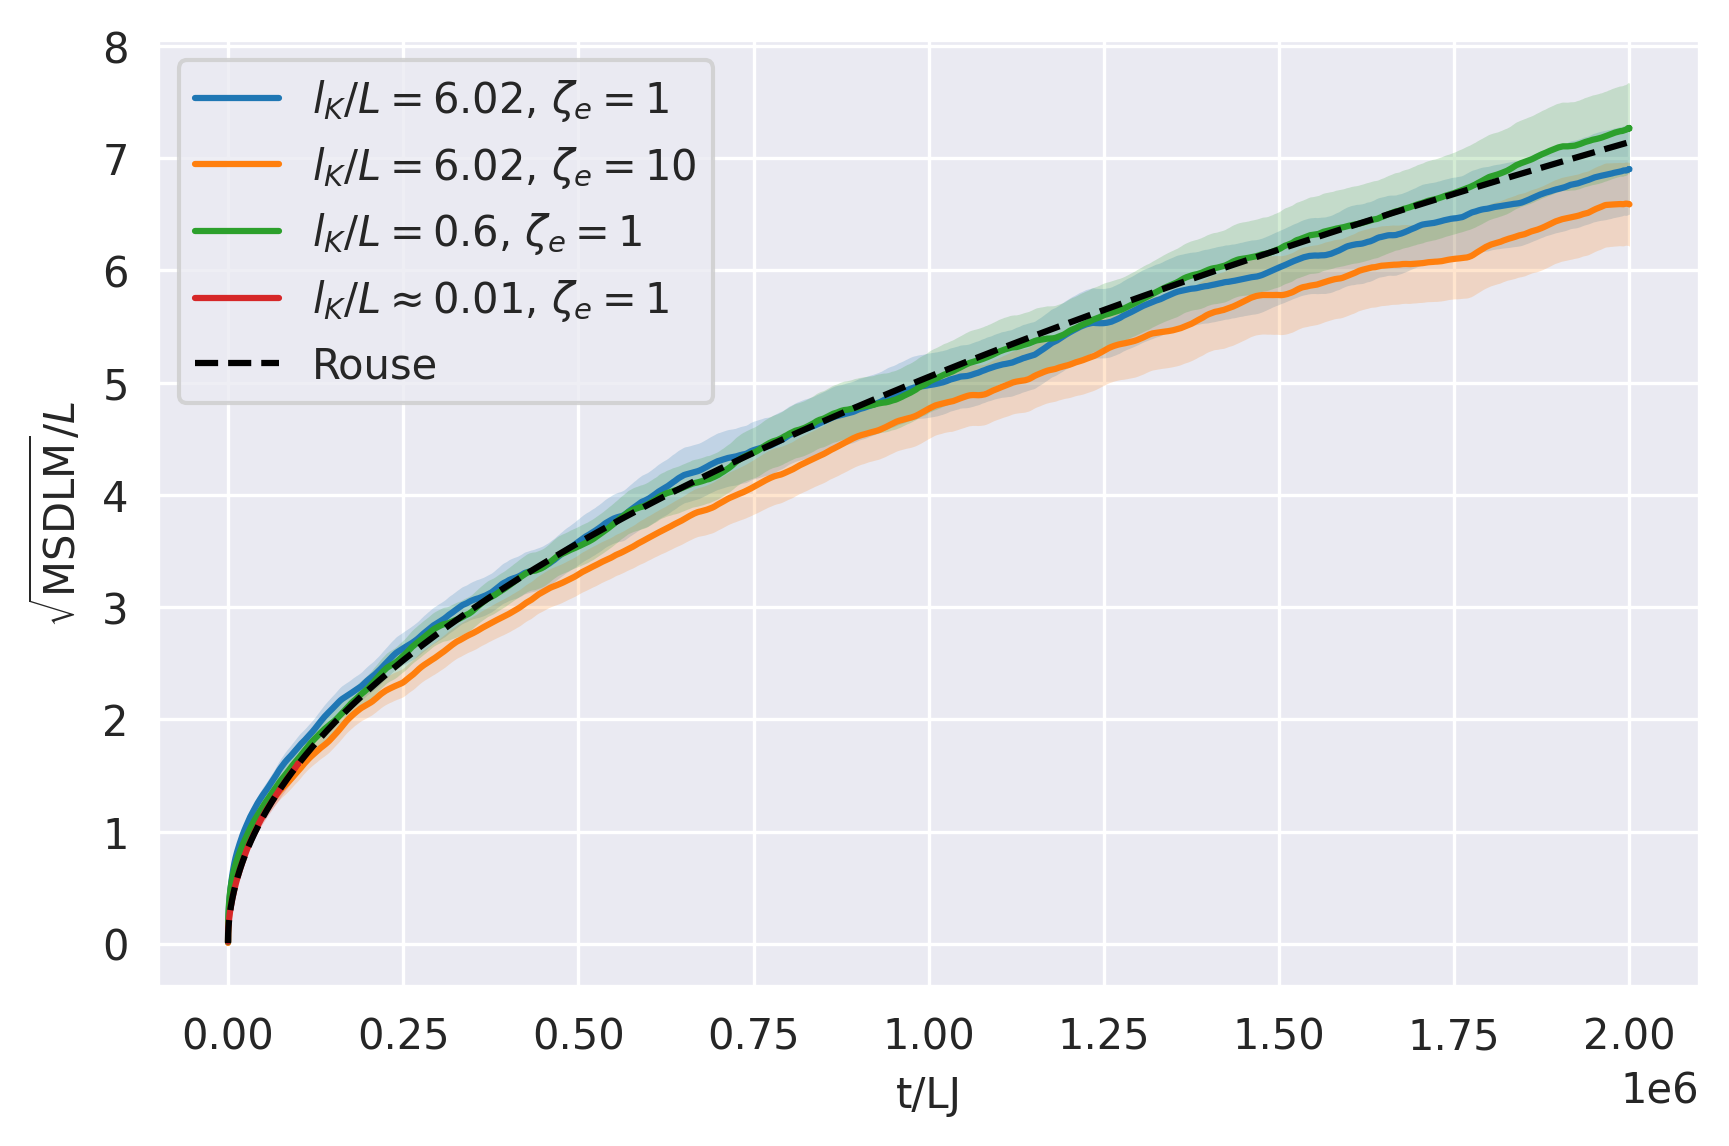

In [23]:
fig, ax = plt.subplots()

for experiment, color in zip(experiments, sns.color_palette()):
    print(f"Plotting {experiment['n']} ...")

    msd_plot.plot_MSD(
        experiment["df_msdlm"],
        log_scale=False,
        l_K=experiment["l_K"],
        L_contour=L_contour,
        zeta=zeta,
        zeta_e=experiment["zeta_e"],
        col="dr_N^2",
        label=experiment["label"],
        ax=ax,
        title="",
        ylabel="",
        xlabel="",
        scatter=False,
        marker_size=2,
        color=color
    )

ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--",
        color="black")

ax.set(xlabel="t/LJ", ylabel="$\sqrt{\\mathrm{MSDLM}}/L$")

ax.legend(loc="upper left")

Plotting 17 ...
Plotting 18 ...
Plotting 19 ...
Plotting 20 ...


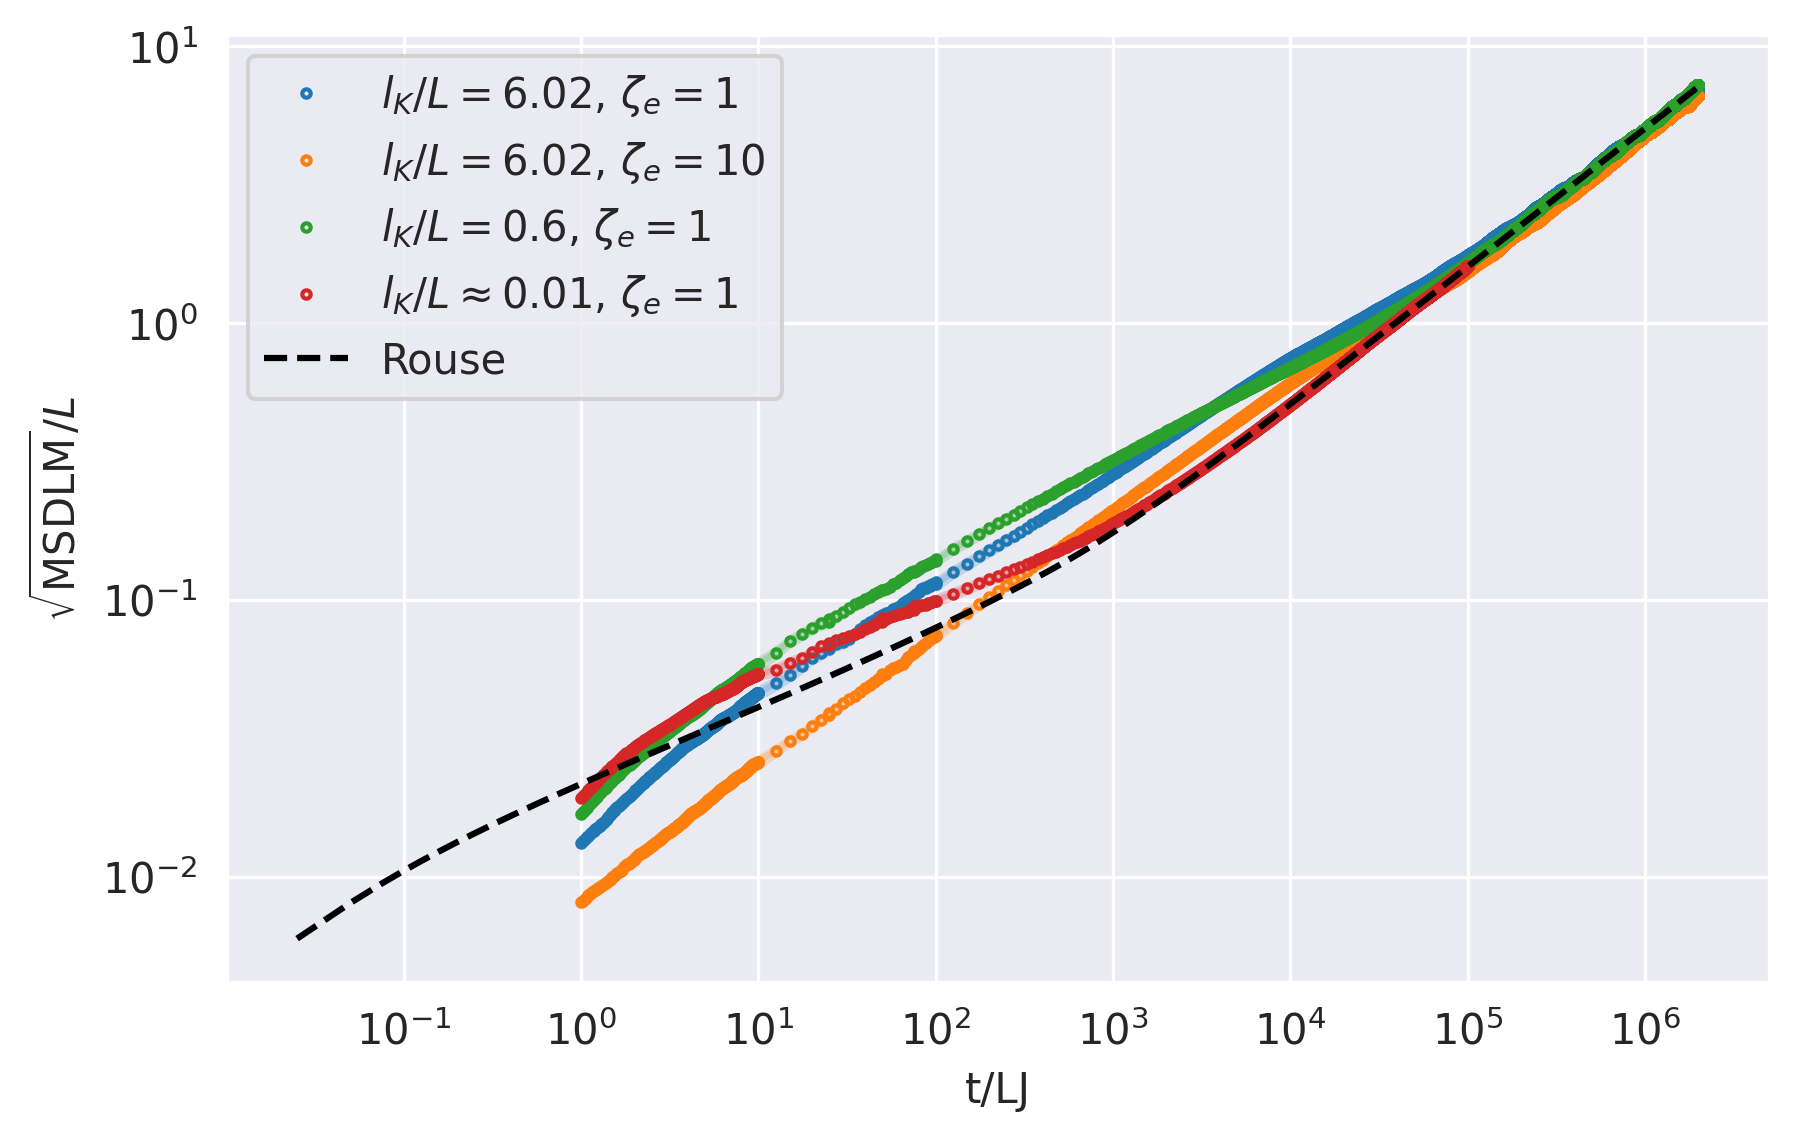

In [24]:
fig, ax = plt.subplots()

for experiment, color in zip(experiments, sns.color_palette()):
    print(f"Plotting {experiment['n']} ...")

    msd_plot.plot_MSD(
        experiment["df_msdlm"],
        log_scale=True,
        l_K=experiment["l_K"],
        L_contour=L_contour,
        zeta=zeta,
        zeta_e=experiment["zeta_e"],
        col="dr_N^2",
        label=experiment["label"],
        ax=ax,
        title="",
        ylabel="",
        xlabel="",
        scatter=True,
        marker_size=2,
        color=color
    )

ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--",
        color="black")

ax.set(xlabel="t/LJ", ylabel="$\sqrt{\\mathrm{MSDLM}}/L$")

ax.legend(loc="upper left")

In [25]:
from scipy.special import gamma


def tau_1_rod_limit(tau_0: float, L: float, l_p: float, l_b: float) -> float:
    return tau_0 * L ** 4 / (l_p * l_b ** 3)


def tau_1_coil_limit(tau_0: float, l_p: float, l_b: float) -> float:
    return tau_0 * (l_p / l_b) ** 3


def ete_ac_interim_t_large(t, tau_0, L, l_b, l_p, k=1):
    # Nikoubashman (C9)
    tau_rot = tau_0 * L ** 2 * l_p / l_b ** 3
    return k * np.exp(-t / tau_rot)


def ete_ac_interim_t_small(t, tau_0, L, l_b, l_p, k=1):
    # Nikoubashman (C10)
    return 1 - k * l_b ** (9 / 4) / (L * l_p ** (5 / 4)) * (t / tau_0) ** (3 / 4)


def ete_ac_rod_limit_t_large(t, tau_0, L, l_b, k=1):
    # Nikoubashman (C3) 
    # t > tau_1
    tau_rot = tau_0 * (L / l_b) ** 3
    return k * np.exp(-t / tau_rot)


def ete_ac_rod_limit_t_small(t, tau_0, L, l_b, l_p, k=1):
    # Nikoubashman (C4)
    # tau_0 < t < tau_1 
    return k * np.exp(
        -(8 * gamma(1 / 4)) / (3 * np.pi) * l_b ** (9 / 4) / (L ** 2 * l_p ** (1 / 4)) * (t / tau_0) ** (3 / 4))



Experiment: $l_K/L=6.02$, $\zeta_e=1$: 100%|██████████| 40436/40436 [00:44<00:00, 903.57it/s] 


,t/LJ,alpha,delta alpha,delta t,interval,count
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0500,1.369951,0.081536,0.0250,"(0.02500000000873115, 0.07499999999708962)",3.0
3,0.0750,1.409394,0.135898,0.0250,"(0.05000000000291038, 0.10000000000582077)",3.0
4,0.0875,1.409316,0.091492,0.0375,"(0.05000000000291038, 0.125)",4.0
...,...,...,...,...,...,...
40431,658050.0000,0.927863,0.000922,341850.0000,"(316200.0, 999900.0)",27349.0
40432,658075.0000,0.927865,0.000922,341850.0000,"(316225.0, 999925.0)",27349.0
40433,658087.5000,0.927864,0.000922,341862.5000,"(316225.0, 999950.0)",27350.0
40434,658100.0000,0.927863,0.000922,341875.0000,"(316225.0, 999975.0)",27351.0


Experiment: $l_K/L=6.02$, $\zeta_e=10$: 100%|██████████| 40436/40436 [00:44<00:00, 915.76it/s] 


,t/LJ,alpha,delta alpha,delta t,interval,count
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0500,1.326634,0.085094,0.0250,"(0.02500000000873115, 0.07499999999708962)",3.0
3,0.0750,1.371310,0.138234,0.0250,"(0.05000000000291038, 0.10000000000582077)",3.0
4,0.0875,1.369263,0.090702,0.0375,"(0.05000000000291038, 0.125)",4.0
...,...,...,...,...,...,...
40431,658050.0000,1.002413,0.000913,341850.0000,"(316200.0, 999900.0)",27349.0
40432,658075.0000,1.002405,0.000913,341850.0000,"(316225.0, 999925.0)",27349.0
40433,658087.5000,1.002407,0.000913,341862.5000,"(316225.0, 999950.0)",27350.0
40434,658100.0000,1.002409,0.000913,341875.0000,"(316225.0, 999975.0)",27351.0


Experiment: $l_K/L=0.6$, $\zeta_e=1$: 100%|██████████| 40436/40436 [00:39<00:00, 1033.10it/s]


,t/LJ,alpha,delta alpha,delta t,interval,count
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0500,1.450413,0.078677,0.0250,"(0.02500000000873115, 0.07499999999708962)",3.0
3,0.0750,1.531656,0.129325,0.0250,"(0.05000000000291038, 0.10000000000582077)",3.0
4,0.0875,1.542699,0.087123,0.0375,"(0.05000000000291038, 0.125)",4.0
...,...,...,...,...,...,...
40431,658050.0000,0.975282,0.000843,341850.0000,"(316200.0, 999900.0)",27349.0
40432,658075.0000,0.975325,0.000843,341850.0000,"(316225.0, 999925.0)",27349.0
40433,658087.5000,0.975325,0.000843,341862.5000,"(316225.0, 999950.0)",27350.0
40434,658100.0000,0.975324,0.000843,341875.0000,"(316225.0, 999975.0)",27351.0


Experiment: $l_K/L \approx 0.01$, $\zeta_e=1$: 100%|██████████| 4440/4440 [00:01<00:00, 2435.42it/s]


,t/LJ,alpha,delta alpha,delta t,interval,count
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0500,1.440123,0.084404,0.0250,"(0.02500000000145519, 0.07500000000436557)",3.0
3,0.0750,1.559732,0.139053,0.0250,"(0.05000000000291038, 0.09999999999854481)",3.0
4,0.0875,1.574944,0.092481,0.0375,"(0.05000000000291038, 0.125)",4.0
...,...,...,...,...,...,...
4435,65812.5000,0.980935,0.002833,34187.5000,"(31625.0, 100000.0)",2736.0
4436,65837.5000,0.980963,0.002835,34187.5000,"(31650.0, 100025.0)",2736.0
4437,65850.0000,0.980970,0.002834,34200.0000,"(31650.0, 100050.0)",2737.0
4438,65862.5000,0.980977,0.002833,34212.5000,"(31650.0, 100075.0)",2738.0


,$\zeta_e$,$l_K/L$,$\tau_1$,$\tau_b$,$\tau_0$,$\alpha_{min}$,$\Delta \alpha_{min}$,$\alpha_{ref}$
0,1.0,6.020000,78162.53,11.00,0.94,0.715,0.005,0.750000
1,10.0,6.020000,781625.32,1.65,9.41,0.770,0.004,0.750000
2,1.0,0.600000,6352.27,11.00,0.94,0.653,0.007,0.666667
3,1.0,0.015873,0.12,11.00,0.94,0.485,0.050,0.666667


\begin{tabular}{rrlllrrr}
\toprule
$\zeta_e$ & $l_K/L$ & $\tau_1$ & $\tau_b$ & $\tau_0$ & $\alpha_{min}$ & $\Delta \alpha_{min}$ & $\alpha_{ref}$ \\
\midrule
1.000000 & 6.020000 & 78162.53 & 11.00 & 0.94 & 0.715000 & 0.005000 & 0.750000 \\
10.000000 & 6.020000 & 781625.32 & 1.65 & 9.41 & 0.770000 & 0.004000 & 0.750000 \\
1.000000 & 0.600000 & 6352.27 & 11.00 & 0.94 & 0.653000 & 0.007000 & 0.666667 \\
1.000000 & 0.015873 & 0.12 & 11.00 & 0.94 & 0.485000 & 0.050000 & 0.666667 \\
\bottomrule
\end{tabular}


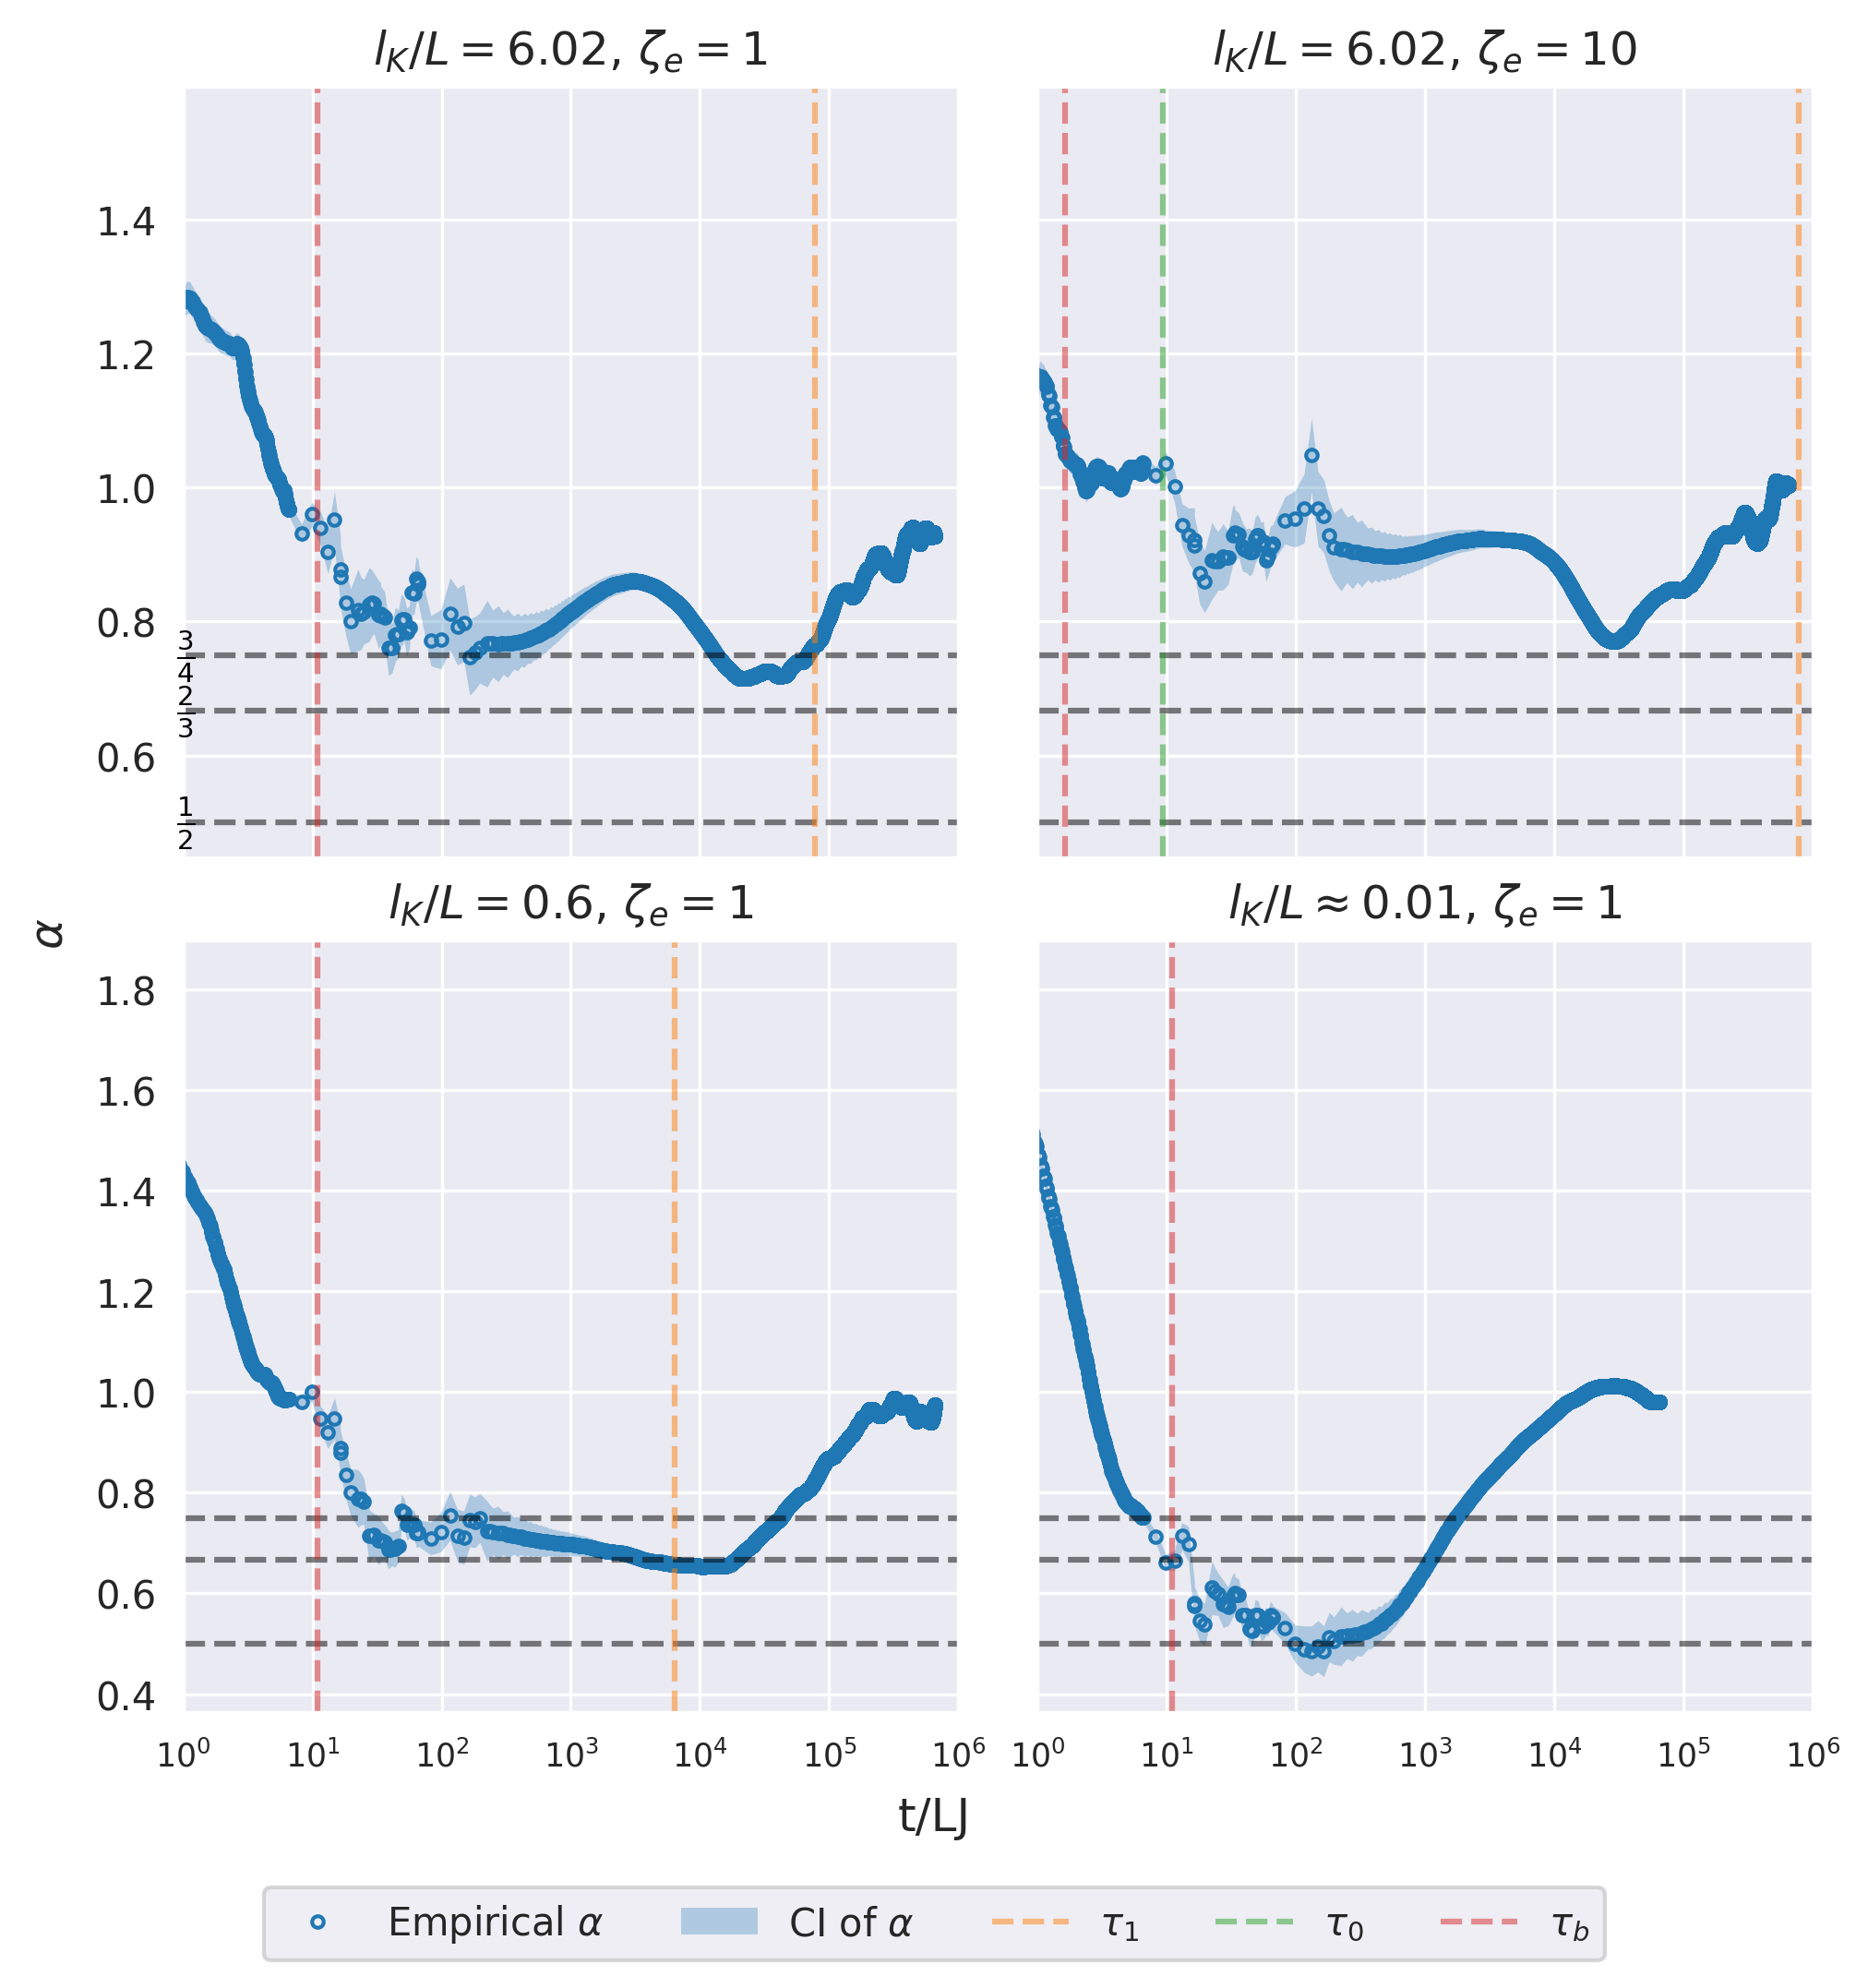

In [39]:
import matplotlib.transforms as transforms

from scipy.optimize import curve_fit
import multiprocessing.pool
import tqdm


def linregbin(df):
    col = "dr_N^2"
    if len(df) < 3:
        return pd.Series([np.NAN, np.NAN, np.NAN, np.NAN, np.NAN, np.NAN], index=["t/LJ", "alpha", "delta alpha", "delta t", "interval", "count"])
    f = lambda x, k: k * x
    xs = np.log10(df["t/LJ"])
    ys = np.log10(df[col])
    xs = xs - xs.min()
    ys = ys - ys.min()
    if f"delta {col}" in df.columns:
        dr = df[col]
        sigma_dr = df[f"delta {col}"] / 3
        dys = np.abs(1 / (dr * np.log(10)) * sigma_dr)
        popt, pcov = curve_fit(f, xs, ys, p0=(0.0), sigma=dys, absolute_sigma=True)
    else:
        popt, pcov = curve_fit(f, xs, ys, p0=(0.0))
    delta_alpha = np.sqrt(np.diag(pcov)[0]) * 3
    t_min = df["t/LJ"].min()
    t_max = df["t/LJ"].max()
    delta_t = (t_max - t_min) / 2
    t = t_min + delta_t
    return pd.Series(
        [t, popt[0], delta_alpha, delta_t, (t_min, t_max), df.shape[0]],
        index=["t/LJ", "alpha", "delta alpha", "delta t", "interval", "count"]
    )

def estimate_alpha(
        scatter: bool = False,
        markersize: int = 5,
        log_window_size: float = 1,
        calculate_alpha: bool = True,
        t_end: float = 1e6,
):
    
    ax: plt.Axes
    fig, axs = plt.subplots(
        ncols=2,
        nrows=2,
        figsize=plot_utils.get_figure_size(
            width=1.0,
            n_rows=2,
            height=1
        ),
        sharex="all",
        sharey="row",
        layout="constrained"
    )
    axs = axs.flatten()
    
    data = []
    
    for experiment, ax in zip(experiments, axs):
        
        if not "df_alpha" in experiment or calculate_alpha:
            df = experiment["df_msdlm"]
            df = df.loc[df["t/LJ"]<=t_end]
            # Estimate alpha
            t_like_log_index = pd.TimedeltaIndex(
                np.log10(df["t/LJ"]), 
                unit='seconds', 
                name="log10(t/LJ)"
            )
            df = df.set_index(t_like_log_index)
            rolling_window_iter = df.rolling(window=pd.Timedelta(log_window_size, unit="s"), min_periods=3)
            with multiprocessing.pool.Pool(processes=32) as p:
                results = tqdm.tqdm(
                    p.imap(linregbin, rolling_window_iter, chunksize=20), 
                    total=df.shape[0],
                    leave=True,
                    position=0,
                    desc=f"Experiment: {experiment['label']}"
                )
                experiment["df_alpha"] = pd.DataFrame(results)
                display(experiment["df_alpha"])
        
        plot_kwargs = {}
        if scatter:
            plot_kwargs["linestyle"] = 'None'
            plot_kwargs["markersize"] = markersize
            plot_kwargs["markerfacecolor"] = 'none'
            plot_kwargs["markeredgecolor"] = sns.color_palette()[0]
            plot_kwargs["fillstyle"] = 'none'
            plot_kwargs["marker"] = "o"
        
        # Plot empirical
        ax.plot(
            experiment["df_alpha"]["t/LJ"],
            experiment["df_alpha"]["alpha"],
            label="Empirical $\\alpha$",
            **plot_kwargs,
        )
        ax.fill_between(
            experiment["df_alpha"]["t/LJ"],
            y1=experiment["df_alpha"]["alpha"] - experiment["df_alpha"]["delta alpha"],
            y2=experiment["df_alpha"]["alpha"] + experiment["df_alpha"]["delta alpha"],
            linewidth=0,
            color=sns.color_palette()[0],
            alpha=0.3,
            label="CI of $\\alpha$"
        )
            
        ax.set(
            xscale="log", 
            title=experiment["label"],
            xlim=[1, 1e6]
        )
        
        # Plot alpha scales
        ax.axhline(y=2 / 3, color="black", linestyle="--", alpha=0.5)
        ax.axhline(y=3 / 4, color="black", linestyle="--", alpha=0.5)
        ax.axhline(y=1 / 2, color="black", linestyle="--", alpha=0.5)
        
        # Estimate and plot time scales
        tau_0=0.97**2 * experiment["zeta_e"]
        l_p = experiment["l_K"] / 2 * L_contour 
        
        if experiment["l_K"] / 2 > 1:
            tau_1 = tau_1_rod_limit(
                tau_0 = tau_0,
                L = L_contour,
                l_p=l_p,
                l_b=0.97
            )
        else:
            tau_1 = tau_1_coil_limit(
                tau_0 = tau_0,
                l_p=l_p,
                l_b=0.97
            )
        
        experiment["tau_1"] = tau_1
        
        tau_b = experiment["m_e"] / experiment["zeta_e"]
        tau_b = tau_b + 10*tau_b
        
        ax.axvline(x=tau_1, color=sns.color_palette()[1], linestyle="--", alpha=0.5, label="$\\tau_1$")
        ax.axvline(x=tau_0, color=sns.color_palette()[2], linestyle="--", alpha=0.5, label="$\\tau_0$")
        ax.axvline(x=tau_b, color=sns.color_palette()[3], linestyle="--", alpha=0.5, label="$\\tau_b$")
        
        # Estimate alpha min
        alpha_row = experiment["df_alpha"].loc[experiment["df_alpha"]["alpha"].idxmin()]
        
        data.append({
            "$\\zeta_e$": experiment["zeta_e"],
            "$l_K/L$": experiment["l_K"],
            "$\\tau_1$": f"{experiment['tau_1']:.2f}",
            "$\\tau_b$": f"{tau_b:.2f}",
            "$\\tau_0$": f"{tau_0:.2f}",
            "$\\alpha_{min}$": np.round(alpha_row["alpha"], 3), 
            "$\\Delta \\alpha_{min}$": np.round(alpha_row["delta alpha"], 3),
            "$\\alpha_{ref}$": 3/4 if experiment["l_K"] > 1 else 2/3
        })
        
    trans = transforms.blended_transform_factory(
        axs[0].get_yticklabels()[0].get_transform(),
        axs[0].transData
    )
    
    for i in (0,):
        axs[i].text(
            0.05,
            2 / 3,
            "$\\frac{2}{3}$",
            color="black",
            transform=trans,
            ha="right",
            va="center"
        )
        
        axs[i].text(
            0.05,
            3 / 4,
            "$\\frac{3}{4}$",
            color="black",
            transform=trans,
            ha="right",
            va="center"
        )
        
        axs[i].text(
            0.05,
            1 / 2,
            "$\\frac{1}{2}$",
            color="black",
            transform=trans,
            ha="right",
            va="center"
        )
    
    axs[2].set_xticks([1, 10, 1e2, 1e3, 1e4, 1e5, 1e6])
    axs[2].tick_params(axis="x", labelsize="small")
    
    axs[3].set_xticks([1, 10, 1e2, 1e3, 1e4, 1e5, 1e6])
    axs[3].tick_params(axis="x", labelsize="small")
    
    fig.legend(
        *axs[-1].get_legend_handles_labels(), 
        ncol=5, 
        loc='lower center', 
        bbox_to_anchor=(0.5, -0.07)
    )
    fig.supxlabel("t/LJ")
    fig.supylabel("$\\alpha$")
    
    df_vals = pd.DataFrame(data)
    display(df_vals)
        
    print(df_vals.to_latex(index=False))
    
    return df_vals
    
    
df_alpha_min_vals = estimate_alpha(scatter=True, log_window_size=0.5, markersize=3, calculate_alpha=True, t_end=1e6)